In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers


NB_WORDS = 10000
NB_START_EPOCHS = 20
BATCH_SIZE = 512
MAX_LEN = 20

output_path = "./"
source_path = "./Tweets.csv"

In [2]:
def deep_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=0)
    return history

def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train, y_train, epochs=epoch_stop, batch_size=BATCH_SIZE, verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [3]:
df = pd.read_csv(source_path)
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions) 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [5]:
tk = Tokenizer(num_words=NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n', lower=True, char_level=False, split=' ')
tk.fit_on_texts(X_train)

In [6]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [7]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [8]:
X_train_rest, X_val, y_train_rest, y_val = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

In [9]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))

Base Model
Minimum validation loss reached in epoch 4


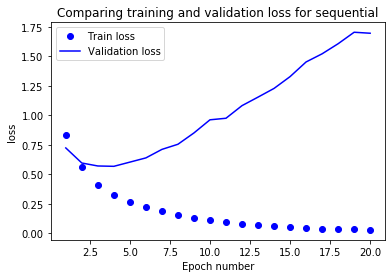

In [10]:
print("Base Model")
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_val, y_val)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

Reduced Model
Minimum validation loss reached in epoch 13


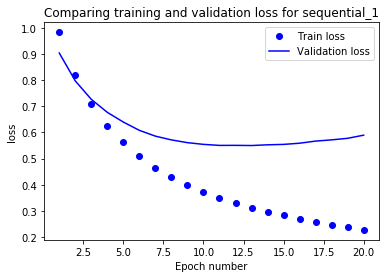

In [11]:
print("Reduced Model")
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_val, y_val)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

base vs. reduced


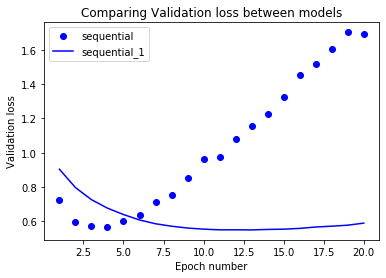

In [12]:
print("base vs. reduced")
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [14]:
print("L2 regularized model")
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_val, y_val)
reg_min = optimal_epoch(reg_history)

L2 regularized model
Minimum validation loss reached in epoch 4


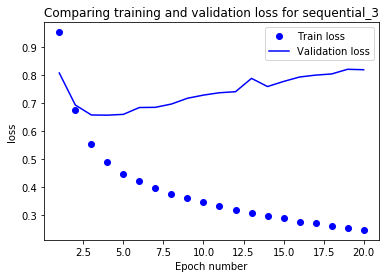

In [15]:
eval_metric(reg_model, reg_history, 'loss')

base vs. L2 reg


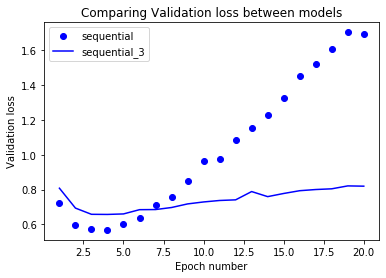

In [16]:
print("base vs. L2 reg")
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

With dropout layers
Minimum validation loss reached in epoch 5


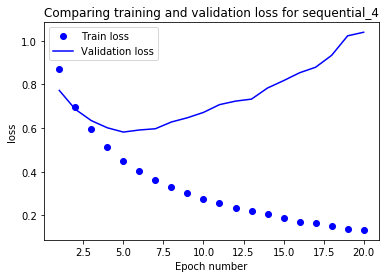

In [17]:
print("With dropout layers")
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_val, y_val)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

base vs. dropout


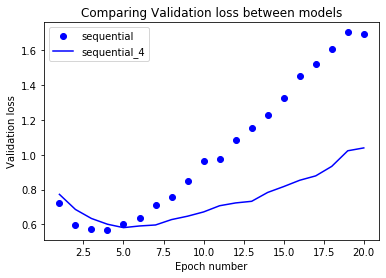

In [18]:
print("base vs. dropout")
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [19]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 4ms/step - loss: 1.0170 - accuracy: 0.7739

Test accuracy: 77.39%
46/46 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.8128

Test accuracy: 81.28%
46/46 [==============================] - 0s 5ms/step - loss: 0.7217 - accuracy: 0.7937

Test accuracy: 79.37%
46/46 [==============================] - 0s 4ms/step - loss: 0.7402 - accuracy: 0.8074

Test accuracy: 80.74%


In [20]:
print("Baseline model: loss: 1.0170 - accuracy: 0.7739")
print("Reduced model: loss: 0.5590 - accuracy: 0.8128")
print("L2 model: loss: 0.7217 - accuracy: 0.7937")
print("Dropout layer model: loss: 0.7402 - accuracy: 0.8074")

Baseline model: loss: 1.0170 - accuracy: 0.7739
Reduced model: loss: 0.5590 - accuracy: 0.8128
L2 model: loss: 0.7217 - accuracy: 0.7937
Dropout layer model: loss: 0.7402 - accuracy: 0.8074
